In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch
from scipy.spatial import Voronoi
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np


# Load data (adjust path/loading method as needed)
df = pd.read_csv('data_to_ml.csv')

In [4]:
# Number of shots per player
shots_by_player = df.groupby('player_name').size().reset_index(name='shots_count')
# Sort descending by shot count
shots_by_player = shots_by_player.sort_values(by='shots_count', ascending=False)

print("Shot count by player:")
print(shots_by_player)

# Number of shots per team
shots_by_club = df.groupby('team_name').size().reset_index(name='shots_count')
# Sort descending by shot count 
shots_by_club = shots_by_club.sort_values(by='shots_count', ascending=False)

print("\nShot count by team:")
print(shots_by_club)

Liczba strzałów wg piłkarzy:
                              player_name  shots_count
3095       Lionel Andrés Messi Cuccittini         2656
3196             Luis Alberto Suárez Díaz          632
3889        Neymar da Silva Santos Junior          466
981   Cristiano Ronaldo dos Santos Aveiro          388
391                  Andrés Iniesta Luján          378
...                                   ...          ...
3642                           Mengwen Li            1
3640                      Melvyn Lorenzen            1
3638                          Melvin Bard            1
3635                         Meleana Shim            1
3691                 Miguel Marcos Madera            1

[5443 rows x 2 columns]

Liczba strzałów wg klubów:
               team_name  shots_count
25             Barcelona         8401
190  Paris Saint-Germain         1432
204          Real Madrid         1188
56           Chelsea FCW         1153
13               Arsenal         1127
..                   ...      

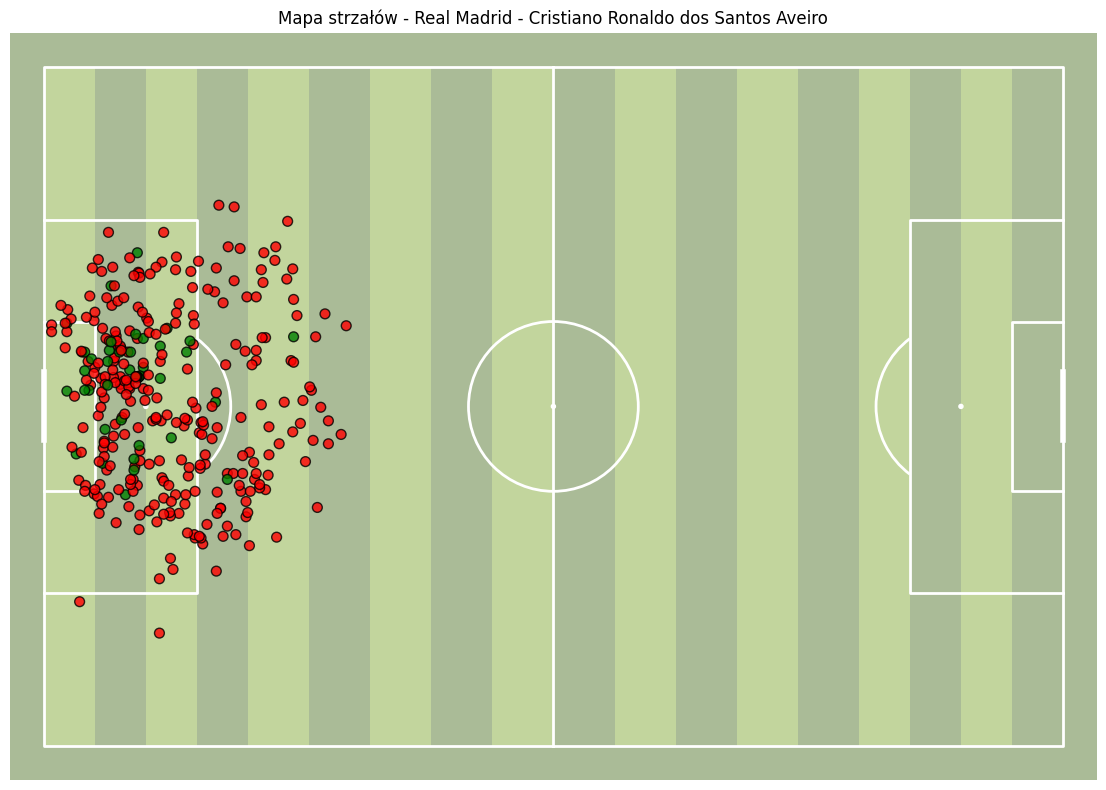

In [9]:
def plot_heatmap(data, club='all', player='all'):
   """
   Plots shot map (scatter) on a football pitch.
   
   Args:
       data: DataFrame containing cols: 'x1', 'y1', 'is_goal', 'team_name', 'player_name'
       club: team name to filter shots (default 'all' - no filter)
       player: player name to filter shots (default 'all' - no filter)
   """
   # Filter data if specific values provided
   df_filtered = data.copy()
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # Make sure 'is_goal' is boolean
   if df_filtered['is_goal'].dtype != 'bool':
       df_filtered['is_goal'] = df_filtered['is_goal'].astype(bool)
   
   # Define colors: goals - green, other shots - red
   colors = {True: 'green', False: 'red'}
   
   # Initialize pitch
   pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)
   fig, ax = pitch.draw(figsize=(12, 8))
   
   # Plot points - each point is shot location (x1, y1)
   ax.scatter(df_filtered['x1'], df_filtered['y1'],
              c = df_filtered['is_goal'].map(colors),
              s = 50,         # marker size
              alpha = 0.8, 
              edgecolors = 'black',
              zorder = 5)
   
   # Set plot title with club/player info if filtering was applied
   title = "Shot Map"
   if club != 'all':
       title += " - " + club
   if player != 'all':
       title += " - " + player
   plt.title(title)
   plt.show()

# Example usage:
# For all shots:
# plot_heatmap(df)

# For Barcelona shots:
# plot_heatmap(df, club='Barcelona')

# For specific Barcelona player (e.g. "CR7"):
plot_heatmap(df, club='Real Madrid', player='Cristiano Ronaldo dos Santos Aveiro')

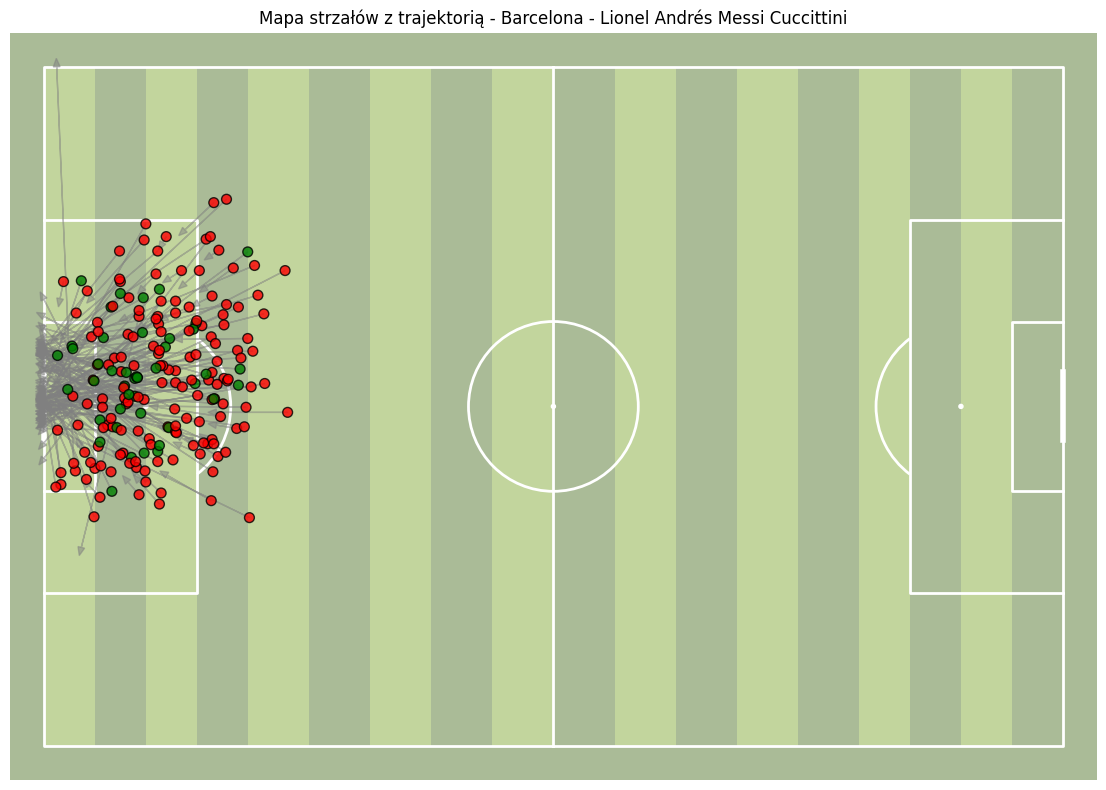

In [11]:
def plot_shot_trajectory(data, club='all', player='all', n=None):
   """
   Plots shot map with trajectories on a football pitch.
   
   Args:
       data: DataFrame with columns:
           'x1', 'y1' - starting shot coordinates
           'x1_end', 'y1_end' - end trajectory coordinates  
           'is_goal' - shot outcome (True if goal, False otherwise)
           'team_name' - club name
           'player_name' - player name
       club: Team name to filter data. Default 'all' (no filter)
       player: Player name to filter. Default 'all' (no filter)
       n: Optional, number of random shots to plot. If None, uses all data
   """
   # Filter data
   df_filtered = data.copy()
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # If n provided and we have more rows than n, get sample
   if n is not None and len(df_filtered) > n:
       df_plot = df_filtered.sample(n=n, random_state=42)
   else:
       df_plot = df_filtered

   # Make sure 'is_goal' is boolean
   if df_plot['is_goal'].dtype != 'bool':
       df_plot['is_goal'] = df_plot['is_goal'].astype(bool)
   
   # Define colors - goals in green, other shots in red
   colors = {True: 'green', False: 'red'}
   
   # Initialize pitch
   pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)
   fig, ax = pitch.draw(figsize=(12, 8))
   
   # Draw arrows - shot trajectories
   for _, row in df_plot.iterrows():
       ax.arrow(row['x1'], row['y1'],
                row['x1_end'] - row['x1'], row['y1_end'] - row['y1'],
                head_width=0.8, head_length=1.0,
                fc='gray', ec='gray', alpha=0.5, zorder=4)
   
   # Draw points - starting shot locations
   ax.scatter(df_plot['x1'], df_plot['y1'],
              c=df_plot['is_goal'].map(colors),
              s=50, alpha=0.8, edgecolors='black', zorder=5)
   
   # Set plot title
   title = "Shot Map with Trajectories"
   if club != 'all':
       title += " - " + club
   if player != 'all':
       title += " - " + player
   plt.title(title)
   plt.show()

# Example usage:
# For all shots:
# plot_shot_trajectory(df)

# For specific club, e.g. "Barcelona":
# plot_shot_trajectory(df, club='Barcelona')

# For specific player from a club, e.g. "Messi" from Barcelona:
plot_shot_trajectory(df, club='Barcelona', player='Lionel Andrés Messi Cuccittini', n=200)

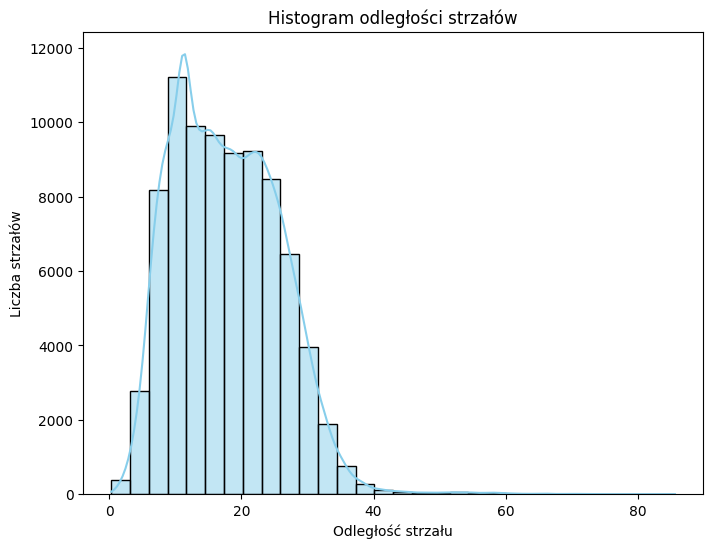

In [12]:
def plot_distance_histogram(data, club='all', player='all', bins=30):
   """
   Plots histogram of shot distances with KDE curve overlay.
   
   Args:
       data: DataFrame with 'distance' column and optional 'team_name'/'player_name'
       club: Team name to filter shots. Default 'all' (no filter)
       player: Player name to filter shots. Default 'all' (no filter) 
       bins: Number of histogram bins (default 30)
   """
   # Copy data to avoid modifying original DataFrame
   df_filtered = data.copy()
   
   # Filter by club if specified
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   
   # Filter by player if specified 
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # Plot shot distance histogram
   plt.figure(figsize=(8, 6))
   sns.histplot(df_filtered['distance'], bins=bins, kde=True, color='skyblue')
   plt.xlabel("Shot Distance")
   plt.ylabel("Number of Shots")
   
   # Set title with club/player info if filtered
   title = "Shot Distance Histogram"
   if club != 'all':
       title += " - " + club
   if player != 'all':
       title += " - " + player
   plt.title(title)
   
   plt.show()

# Example usage:
# For all data:
plot_distance_histogram(df)

# For specific club e.g. "Barcelona":
# plot_distance_histogram(df, club='Barcelona')

# For specific player from a club e.g. "Messi" from Barcelona:
# plot_distance_histogram(df, club='Barcelona', player='Messi')

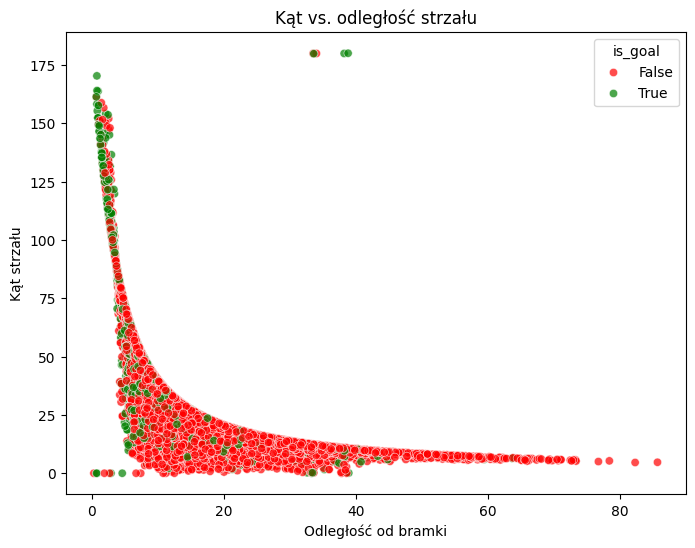

In [15]:
def plot_angle_distance(data, club='all', player='all'):
   """
   Plots scatter plot showing relationship between shot distance and angle.
   
   Args:
       data: DataFrame with cols: 'distance', 'angle', 'is_goal', 'team_name', 'player_name'
       club: Team name (e.g. "Barcelona"). Default 'all' - no filter
       player: Player name. Default 'all' - no filter
   """
   # Copy data to avoid modifying original
   df_filtered = data.copy()
   
   # Filter by club if specified
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   
   # Filter by player if specified
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # Make sure 'is_goal' is boolean
   if df_filtered['is_goal'].dtype != 'bool':
       df_filtered['is_goal'] = df_filtered['is_goal'].astype(bool)
   
   # Define colors - goals green, other shots red
   colors = {True: 'green', False: 'red'}
   
   # Plot scatter
   plt.figure(figsize=(8, 6))
   sns.scatterplot(data=df_filtered, x='distance', y='angle', 
                   hue='is_goal', palette=colors, alpha=0.7)
   plt.xlabel("Shot Distance")
   plt.ylabel("Shot Angle")
   
   # Set title with filter info
   title = "Angle vs. Distance of Shots"
   if club != 'all':
       title += " - " + club
   if player != 'all':
       title += " - " + player
   plt.title(title)
   plt.show()

# Example usage:
# For all data:
plot_angle_distance(df)

# For specific club e.g. "Barcelona":
# plot_angle_distance(df, club='Barcelona')

# For specific player e.g. "Messi" from Barcelona:
# plot_angle_distance(df, club='Barcelona', player='Messi')

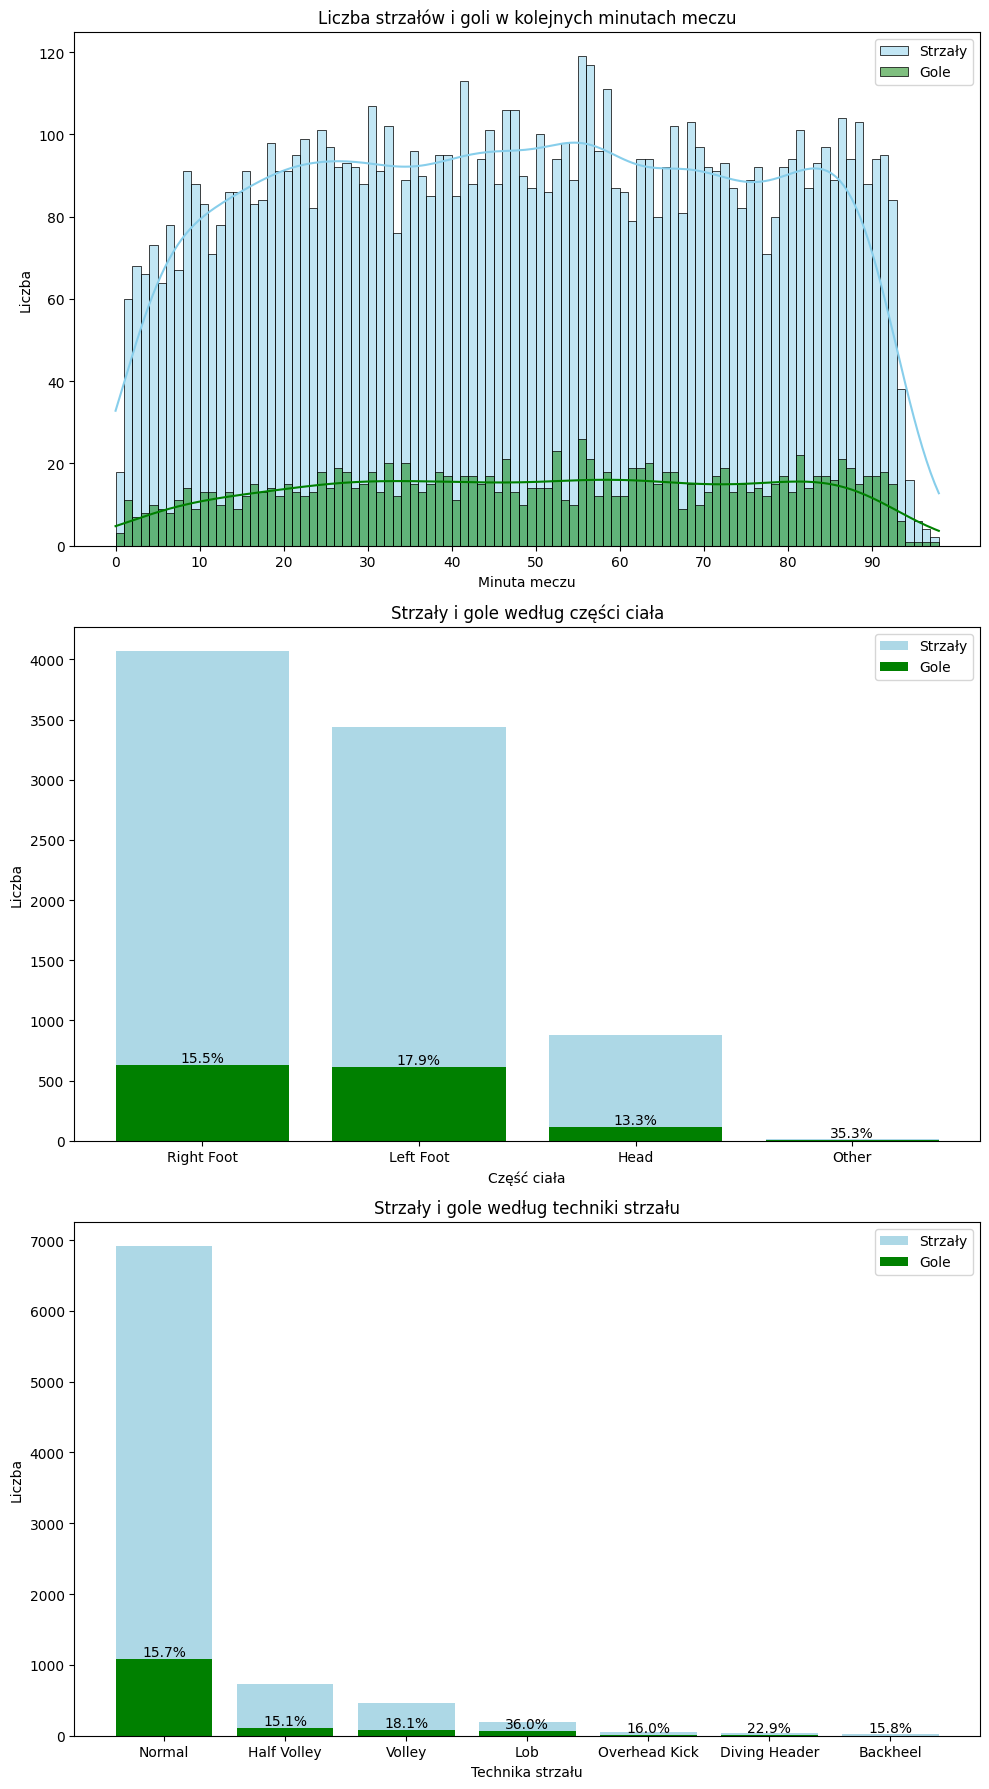

In [18]:
def plot_shot_statistics(data, club='all', player='all'):
   """
   Plots three visualizations about shots:
     1. Histogram of shots and goals by match minute
     2. Bar plot - shots and goals by body part
     3. Bar plot - shots and goals by shot technique
   
   Args:
       data: DataFrame with columns:
           'minute', 'is_goal', 'shot_body_part_name', 'shot_technique_name',
           'team_name', 'player_name'
       club: Team name to filter data (default 'all' - no filter)
       player: Player name to filter data (default 'all' - no filter)
   """
   # Filter data
   df_filtered = data.copy()
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # Make sure 'is_goal' is boolean
   if df_filtered['is_goal'].dtype != 'bool':
       df_filtered['is_goal'] = df_filtered['is_goal'].astype(bool)
   
   # -------------------------------
   # Plot 1: Histogram of shots/goals by minute
   # -------------------------------
   max_minute = df_filtered['minute'].max()
   bins = np.arange(0, max_minute + 1, 1)
   
   fig, axs = plt.subplots(3, 1, figsize=(10, 18))
   
   # All shots histogram (skyblue) with KDE
   sns.histplot(data=df_filtered, x='minute', bins=bins, color='skyblue', 
                kde=True, stat='count', alpha=0.5, ax=axs[0], label='Shots')
   # Goals histogram (filter: is_goal==True, green)
   sns.histplot(data=df_filtered[df_filtered['is_goal'] == True], x='minute', bins=bins, color='green', 
                kde=True, stat='count', alpha=0.5, ax=axs[0], label='Goals')
   axs[0].set_xlabel("Match Minute")
   axs[0].set_ylabel("Count")
   axs[0].set_title("Shots and Goals by Match Minute")
   axs[0].set_xticks(np.arange(0, max_minute + 1, 10))
   axs[0].legend()
   
   # -------------------------------
   # Plot 2: Bar plot by shot_body_part_name
   # -------------------------------
   df_body = df_filtered.groupby('shot_body_part_name', as_index=False).agg(
       total_shots=('is_goal', 'count'),
       goals=('is_goal', 'sum')
   ).sort_values(by='total_shots', ascending=False)
   
   x = np.arange(len(df_body))
   # Background bar: all shots (lightblue)
   bar_total = axs[1].bar(x, df_body['total_shots'], color='lightblue', label='Shots')
   # Overlay bar: goals (green)
   bar_goals = axs[1].bar(x, df_body['goals'], color='green', label='Goals')
   
   axs[1].set_xticks(x)
   axs[1].set_xticklabels(df_body['shot_body_part_name'], rotation=0)
   axs[1].set_xlabel('Body Part')
   axs[1].set_ylabel('Count')
   axs[1].set_title('Shots and Goals by Body Part')
   axs[1].legend()
   
   # Add annotation - goal percentage above green bar
   for rect, (_, row) in zip(bar_goals, df_body.iterrows()):
       height = rect.get_height()
       x_center = rect.get_x() + rect.get_width() / 2
       percent = (row['goals'] / row['total_shots']) * 100 if row['total_shots'] > 0 else 0
       axs[1].text(x_center, height + 0.5, f'{percent:.1f}%', ha='center', va='bottom', color='black')
   
   # -------------------------------
   # Plot 3: Bar plot by shot_technique_name
   # -------------------------------
   df_tech = df_filtered.groupby('shot_technique_name', as_index=False).agg(
       total_shots=('is_goal', 'count'),
       goals=('is_goal', 'sum')
   ).sort_values(by='total_shots', ascending=False)
   
   x2 = np.arange(len(df_tech))
   bar_total2 = axs[2].bar(x2, df_tech['total_shots'], color='lightblue', label='Shots')
   bar_goals2 = axs[2].bar(x2, df_tech['goals'], color='green', label='Goals')
   
   axs[2].set_xticks(x2)
   axs[2].set_xticklabels(df_tech['shot_technique_name'], rotation=0)
   axs[2].set_xlabel('Shot Technique')
   axs[2].set_ylabel('Count')
   axs[2].set_title('Shots and Goals by Shot Technique')
   axs[2].legend()
   
   for rect, (_, row) in zip(bar_goals2, df_tech.iterrows()):
       height = rect.get_height()
       x_center = rect.get_x() + rect.get_width() / 2
       percent = (row['goals'] / row['total_shots']) * 100 if row['total_shots'] > 0 else 0
       axs[2].text(x_center, height + 0.5, f'{percent:.1f}%', ha='center', va='bottom', color='black')
   
   plt.tight_layout()
   plt.show()

# Example usage:
# For all data:
# plot_shot_statistics(df)

# For specific club e.g. "Barcelona":
plot_shot_statistics(df, club='Barcelona')

# For specific player e.g. "Messi" from Barcelona:
# plot_shot_statistics(df, club='Barcelona', player='Messi')

In [36]:
def plot_pitch_heatmap(data, x_col, y_col, club='all', player='all', 
                      cmap='Reds', thresh=0.05, alpha=0.7, figsize=(12,8), title=None):
   """
   Draws a heatmap overlay on a full pitch for given coordinates.
   
   Args:
       data: DataFrame with coordinate columns (e.g. 'x1', 'y1')
       x_col: name of column containing x coordinates
       y_col: name of column containing y coordinates  
       club: (optional) team name to filter data (default 'all' - no filter)
       player: (optional) player name to filter data (default 'all')
       cmap: colormap for heatmap (default 'Reds')
       thresh: threshold param passed to sns.kdeplot (default 0.05)
       alpha: heatmap transparency (default 0.7)
       figsize: figure size (default (12,8))
       title: plot title (default auto-generated)
       
   Filters data by club/player if specified and draws full pitch,
   then overlays heatmap for coordinates in x_col and y_col.
   """
   # Filter data if club or player specified
   df_filtered = data.copy()
   if club != 'all':
       df_filtered = df_filtered[df_filtered['team_name'] == club]
   if player != 'all':
       df_filtered = df_filtered[df_filtered['player_name'] == player]
   
   # Initialize pitch
   pitch = Pitch(pitch_color='#aabb97', line_color='white', stripe=True)
   fig, ax = plt.subplots(figsize=figsize)
   pitch.draw(ax=ax)  # Draw full pitch
   
   # Add heatmap (kdeplot) for coordinates in x_col, y_col
   sns.kdeplot(data=df_filtered, x=x_col, y=y_col, fill=True, cmap=cmap, 
               thresh=thresh, alpha=alpha, ax=ax)
   
   # Set plot title
   if title is None:
       title = "Heatmap"
       if club != 'all':
           title += " - " + club
       if player != 'all':
           title += " - " + player
   ax.set_title(title)
   
   plt.show()

In [37]:
# --- Aggregate opponent positions ---
opponent_x_cols = [col for col in df.columns if col.startswith('x_player_opponent')]
opponent_positions = []
for x_col in opponent_x_cols:
   suffix = x_col.replace("x_player_opponent_", "")
   y_col = "y_player_opponent_" + suffix
   if y_col in df.columns:
       # Include additional columns if available:
       cols = [x_col, y_col]
       if 'team_name' in df.columns:
           cols.append('team_name')
       if 'player_name' in df.columns:
           cols.append('player_name')
           
       tmp = df[cols].dropna()
       if not tmp.empty:
           # Rename x and y columns to consistent "x" and "y"
           rename_dict = {x_col: "x", y_col: "y"}
           tmp = tmp.rename(columns=rename_dict)
           opponent_positions.append(tmp)
if opponent_positions:
   df_opponents = pd.concat(opponent_positions, ignore_index=True)
else:
   # Create empty DataFrame with proper columns
   cols = ["x", "y"]
   if 'team_name' in df.columns:
       cols.append("team_name")
   if 'player_name' in df.columns:
       cols.append("player_name")
   df_opponents = pd.DataFrame(columns=cols)

# --- Aggregate teammate positions ---
teammate_x_cols = [col for col in df.columns if col.startswith('x_player_teammate')]
teammate_positions = []
for x_col in teammate_x_cols:
   suffix = x_col.replace("x_player_teammate_", "")
   y_col = "y_player_teammate_" + suffix
   if y_col in df.columns:
       cols = [x_col, y_col]
       if 'team_name' in df.columns:
           cols.append('team_name')
       if 'player_name' in df.columns:
           cols.append('player_name')
           
       tmp = df[cols].dropna()
       if not tmp.empty:
           tmp = tmp.rename(columns={x_col: "x", y_col: "y"})
           teammate_positions.append(tmp)
if teammate_positions:
   df_teammates = pd.concat(teammate_positions, ignore_index=True)
else:
   cols = ["x", "y"]
   if 'team_name' in df.columns:
       cols.append("team_name")
   if 'player_name' in df.columns:
       cols.append("player_name")
   df_teammates = pd.DataFrame(columns=cols)

# Split shots by outcome
df_shots_goal = df[df['is_goal'] == True].copy()
df_shots_no_goal = df[df['is_goal'] == False].copy()

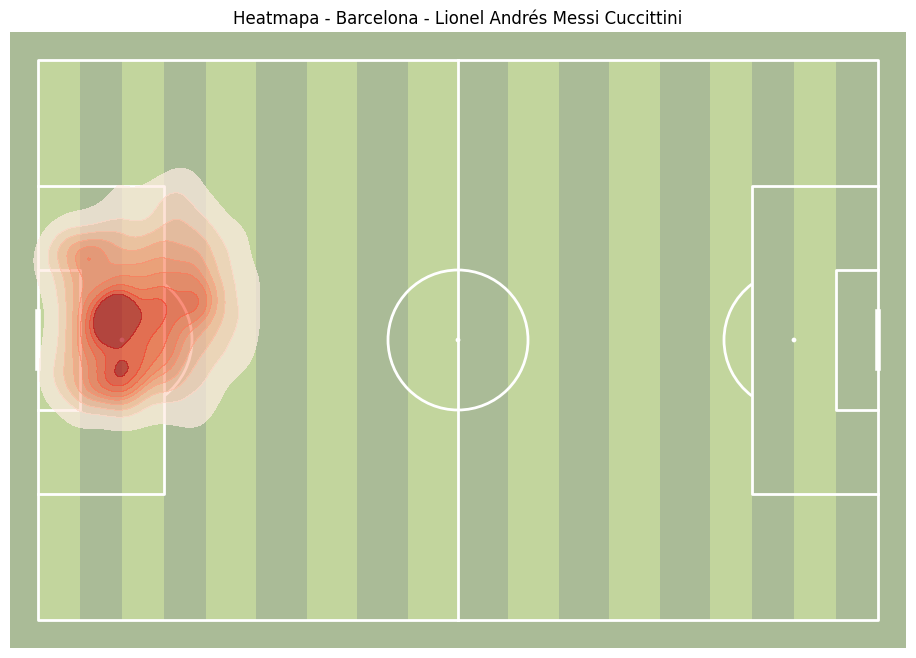

In [38]:
# Example usage:
# Shot heatmap (e.g. 'x1' and 'y1' coordinates) for all data:
# plot_pitch_heatmap(df, x_col='x1', y_col='y1')

# Shot heatmap for specific club, e.g. "Barcelona":
plot_pitch_heatmap(df, x_col='x1', y_col='y1', club='Barcelona', player='Lionel Andrés Messi Cuccittini')

# Position heatmap (e.g. 'x' and 'y' from df_opponents) for specific player or club:
# plot_pitch_heatmap(df_opponents, x_col='x', y_col='y', club='Chelsea FCW')